# Machine Learning Engineer Nanodegree
## Capstone
## Project: Quora Question Pairs
Determine if a pair of questions submitted to Quora are duplicates with the same intent.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd

### Data Exploration

In [2]:
train_data = pd.read_csv("train.csv")
train_data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
num_questions = len(train_data)
print "Question Pairs: ", num_questions
question_ids = pd.Series(train_data['qid1'].tolist() + train_data['qid2'].tolist())
print "Unique Questions: %d" %len(np.unique(question_ids))
groupby_duplicates = train_data.groupby("is_duplicate")['id'].count()
known_duplicates = groupby_duplicates[1]
print "Known Duplicates: ", known_duplicates
ratio_duplicates = round((known_duplicates / float(num_questions)) * 100, 2)
print  "Ratio of Duplicate Pairs: ", ratio_duplicates, "%"

Question Pairs:  404290
Unique Questions: 537933
Known Duplicates:  149263
Ratio of Duplicate Pairs:  36.92 %


In [4]:
test_data = pd.read_csv("test.csv")
test_data.head(5)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [5]:
test_question_pairs = len(test_data)
print "Question Pairs: ", test_question_pairs

Question Pairs:  2345796


### Exploratory Visualization
#### Word Cloud
I will begin by generating a word cloud to get an idea of the topics our questions will be about. The larger words represent words that appear most often and will give us an idea of overall themes or patterns we might see across the dataset.

In [6]:
# import libs for visualization
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords=set(STOPWORDS)

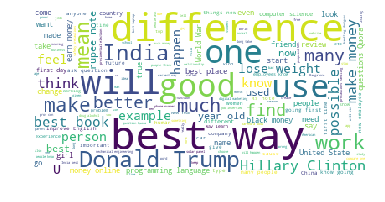

In [7]:
# Combine all questions for creating single wordcloud
train_all_questions = pd.Series(" ".join(train_data['question1'].astype(str)) + " ".join(train_data['question2'].astype(str)))

# Generate a word cloud image
train_wordcloud = WordCloud(
                            background_color='white',
                            stopwords=stopwords,
                            max_font_size=50
                           ).generate(" ".join(train_all_questions))

# Display the generated image
fig = plt.figure(1)
plt.imshow(train_wordcloud)
plt.axis("off")
plt.show()

# Save the image for the report
fig.savefig("wordcloud.png", dpi=900)

Next, I will write a few functions to begin collecting features about the data. I will look at the number of words, the number of characters, and how many words the questions have in common for each record.

In [8]:
def get_char_count(question):
    return len(str(question))

def get_word_count(question):
    return len(str(question).split())

def get_common_word_count(questions):
    q1, q2 = questions
    q1_set = set(str(q1).lower().split())
    q2_set = set(str(q2).lower().split())
    return len(q1_set & q2_set)

In [9]:
# Create a DataFrame to hold the extracted features
train_feats = pd.DataFrame(dtype='float64')

# Get the number of characters in each question
train_feats['q1_chars'] = train_data['question1'].map(get_char_count)
train_feats['q2_chars'] = train_data['question2'].map(get_char_count)

# Get the number of words in each question
train_feats['q1_words'] = train_data['question1'].map(get_word_count)
train_feats['q2_words'] = train_data['question2'].map(get_word_count)

# Get the number of common words. 
# Use .apply since we are working with a Series; 
# axis=1 refers to columns instead of default row calculations
train_feats['common_words'] = train_data[['question1','question2']].apply(get_common_word_count, axis=1)

train_feats.head(5)

,q1_chars,q2_chars,q1_words,q2_words,common_words
0,66,57,14,12,10
1,51,88,8,13,4
2,73,59,14,10,4
3,50,65,11,9,0
4,76,39,13,7,2


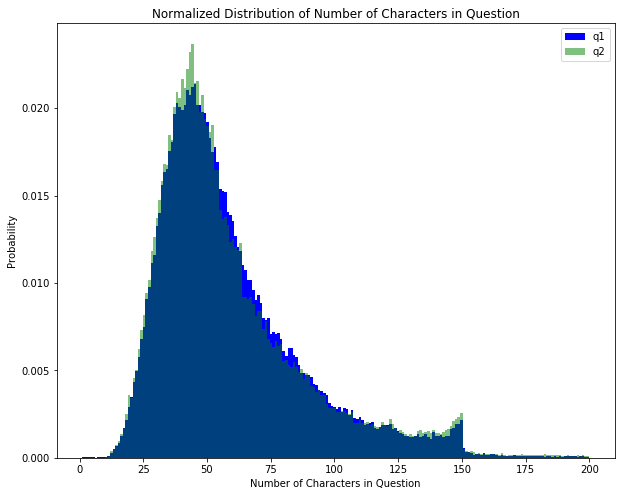

In [10]:
char_graph = plt.figure(1, figsize=(10,8))

plt.hist(train_feats['q1_chars'], range=[1,200], bins=200, color='blue', label='q1', normed=True)
plt.hist(train_feats['q2_chars'], range=[1,200], bins=200, color='green', alpha=0.5, label='q2', normed=True)
plt.xlabel('Number of Characters in Question')
plt.ylabel('Probability')
plt.title('Normalized Distribution of Number of Characters in Question')
plt.legend()
char_graph.savefig("char_graph.png")

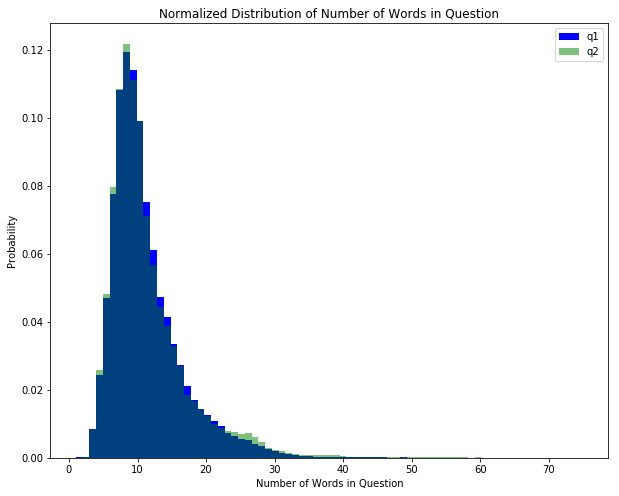

In [11]:
word_graph = plt.figure(1, figsize=(10,8))

plt.hist(train_feats['q1_words'], range=[1,75], bins=75, color='blue', label='q1', normed=True)
plt.hist(train_feats['q2_words'], range=[1,75], bins=75, color='green', alpha=0.5, label='q2', normed=True)
plt.xlabel('Number of Words in Question')
plt.ylabel('Probability')
plt.title('Normalized Distribution of Number of Words in Question')
plt.legend()
word_graph.savefig("word_graph.png")

## Pre-Processing
#### TF-IDF Vectorization
Next we will generate a Tf-idf-weighted term-document matrix. 
Tf-idf is term frequency-inverse document frequency, which is a statistic that reflects the importance of a word in a specific document (in our case, a question) relative to all of the words in a collection of documents known as the corpus (in our case, all of the questions).

In [152]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer
# import tools for Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words='english')

train_data.dropna()

q1s = train_data['question1'].astype(str)
q2s = train_data['question2'].astype(str)

corpus = pd.concat([q1s, q2s])

# Learn the vocabulary dictionary and return term-document matrix. 
tfidf = vectorizer.fit_transform(corpus)

Next, we will split the train_data into training and test sets. We will train using only a portion of our training data from the dataset. This way, we can then run the model against the reamining portion of the training questions and check against the actual value (is_duplicate) to see how accurate our model is.

In [114]:
# Transform Q1s and Q2s to their vector representations
tr1 = tfidf.transform(q1s)
tr2 = tfidf.transform(q2s)

In [176]:
# Calculate the cosine angle between the tr1 (Q1) and tr2 (Q2) vectors to determine how similar they are
cos_sim = []

for i in range(len(train_data)):
    cos_sim = cosine_similarity(tr1[i],tr2[i])
    cos_sim.append(cos_sim[0][0])
    
# Add cosine similarity as a feature for each set    
train_feats['cosine_similarity'] = cos_sim

print train_feats.head()

   q1_chars  q2_chars  q1_words  q2_words  common_words     q1_tf     q2_tf
0        66        57        14        12            10  0.000012  0.000012
1        51        88         8        13             4  0.000012  0.000012
2        73        59        14        10             4  0.000012  0.000012
3        50        65        11         9             0  0.000012  0.000012
4        76        39        13         7             2  0.000012  0.000012


### Benchmark Model

In [186]:
# TODO: Import 'train_test_split'
from sklearn.cross_validation import train_test_split

labels = train_data['is_duplicate']

# TODO: Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(train_feats, labels, test_size=0.2, random_state=0)

In [187]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [189]:
prediction = rfc.predict(X_test)
score = rfc.score(X_test, y_test)

print score

0.7100719780355685
